In [1]:
import numpy as np
from matplotlib import pyplot as plt

import time
import datetime
from config import *
from datetime import timedelta
from binance.client import Client
from BinanceFuturesPy.futurespy import Client as cf

In [2]:
client = Client(api_key, api_secret)
clientf = cf(api_key, api_secret)# , testnet=True)
clientf.change_leverage(1)

{'symbol': 'BTCUSDT', 'leverage': 1, 'maxNotionalValue': '500000000'}

In [3]:
def cheese(depth):
    # depth = client.futures_coin_order_book(symbol='BTCUSD_PERP', pair="B65TCBUSD")
    bid = np.array(depth['bids']).astype(np.float64)
    ask = np.array(depth['asks']).astype(np.float64)
    
    ### price
    b_price = bid[:, 0][0] # compra
    a_price = ask[:, 0][0] # venta
    price = (b_price+a_price)/2
    
    ### order book
    k = 200
    b_prc = bid[:, 0].astype(np.float64)[:k]
    b_ord = bid[:, 1].astype(np.float64)[:k]
    # b_prc = b_prc[b_ord>b_ord.mean()]
    b_vol = b_prc.sum()
    std_b = round(np.std(np.histogram(b_prc)[0]), 3)
    
    a_prc = ask[:, 0].astype(np.float64)[:k]
    a_ord = ask[:, 1].astype(np.float64)[:k]
    # a_prc = a_prc[a_ord>a_ord.mean()]
    a_vol = a_prc.sum()
    std_a = round(np.std(np.histogram(a_prc)[0]), 3)
    
#     total_vol = a_vol+b_vol
#     rel_a = a_vol/total_vol
#     rel_b = b_vol/total_vol
    
    std_b = round(std_b, 1)
    std_a = round(std_a, 1)
    
    # print(std_b, std_a)
    return std_b, std_a, price

In [4]:
# def buy_order():
#     order = clientf.new_order(
#                         # symbol = 'BTCUSDT',
#                         symbol = 'BTCBUSD',
#                         side = 'BUY',
#                         orderType = 'MARKET',
#                         quantity = 1e-3,
#                     )
#     return order

# def sell_order():
#     order = clientf.new_order(
#                         # symbol = 'BTCUSDT',
#                         symbol = 'BTCBUSD',
#                         side = 'SELL',
#                         orderType = 'MARKET',
#                         quantity = 1e-3,
#                     )
#     return order

def buy_order():
    return 1

def sell_order():
    return 0

In [ ]:
i_3 = 0
activo = 0
on = 0
on2 = 0
side = ""
lado1 = 0
lado2 = 0
diff = 0
sl = []
record = []

acc = 0
acc2 = 0

b, a = 0, 0
profit = 0

while True:
    # print(b, a, diff, acc, acc2, end=' ')
    # t = "{} {:.1f} {:.1f} {:.1f} {} {:.3f} {:.3f}".format(i_3, b, a, diff, side, acc, acc2)
    t = "{} {:.1f} {:.1f} {:.1f}".format(i_3, b, a, diff, profit)
    print(t, end=" ")
    # time.sleep(2)
    # price = client.futures_ticker(symbol='BTCUSDT')['lastPrice']
    try:
        # price = 48327.6
        depth = client.futures_coin_order_book(symbol='BTCUSD_PERP', pair="BTCBUSD")
        # price = client.futures_coin_mark_price(symbol='BTCUSD_PERP')
        b, a, price = cheese(depth)

        diff = abs(b-a)
        if diff>=.75 and on==0:
            i_3+=1
        elif diff>=.75 and on==1:
            i_3+=1
        else:
            i_3=0

        if i_3>=4 and activo==0:
            activo=1

        if b>a:
            lado2 = 1
        elif a>b:
            lado2 = -1

        ### 1~
        if activo==1 and on==0:
            if b>a:
                ### venta
                order = sell_order()
                side = "sell"
                lado1 = 1
            elif a>b:
                ### compra
                order = buy_order()
                side = 'buy'
                lado1 = -1
            on=1
            # print("open")
        elif activo==0 and on==1 and side!="":
            if side=="sell":
                order = buy_order()
            else:
                order = sell_order()
            i_3 = 0
            activo = 0
            on = 0
            side = ''
            sl = []
            record = []
            # print("close 1")

        elif activo==1 and on==1 and lado1!=lado2 and side!="":
            if side=="sell":
                order = buy_order()
            elif side=="buy":
                order = sell_order()
            i_3 = 0
            activo = 0
            on = 0
            side = ''
            sl = []
            record = []
            # print("close 2")

        ### 1.5
        if on==1:
            record.append(price)
        
        ###
        if on==1:
            profit = float(clientf.account_info()['assets'][2]['unrealizedProfit'])
            if profit<-.04 and side=='buy':
                order = sell_order()
                i_3 = 0
                activo = 0
                on = 0
                side = ""
                sl = []
                record = []
                # print("close 5")
            elif profit>.04 and side=='sell':
                order = buy_order()
                i_3 = 0
                activo = 0
                on = 0
                side = ""
                sl = []
                record = []
                # print("close 6")

        ### 2
        if len(record)>1:
            acc = (record[-1]-record[-2])/record[-2]
        else:
            acc = 0

        if acc>0:
            acc2 = acc*.57
            sl.append(acc2)
        elif acc<0:
            acc2 = acc*.60
            sl.append(acc2)
        if len(sl)>0:
            if side=='buy':
                stop = max(sl)
                if acc<stop:
                    order = sell_order()
                    i_3 = 0
                    activo = 0
                    on = 0
                    side = ""
                    sl = []
                    record = []
                    # print("close 3")
            elif side=="sell":
                stop = min(sl)
                if acc<stop:
                    order = buy_order()
                    i_3 = 0
                    activo = 0
                    on = 0
                    side = ""
                    sl = []
                    record = []
                    # print("close 4")
                    
    # except requests.exceptions.ConnectTimeout:
    except:
        #print(".", end=" ")
        print("timeout")
        # pass
        if activo==1 and on==1:
            if side=="sell":
                order = buy_order()
            elif side=="buy":
                order = sell_order()
            else:
                pass
            i_3 = 0
            activo = 0
            on = 0
            side = ''
            sl = []
            record = []
            print("close 7")
        time.sleep(15)
    # i_3, b, a, diff, side, acc, acc2
    print()

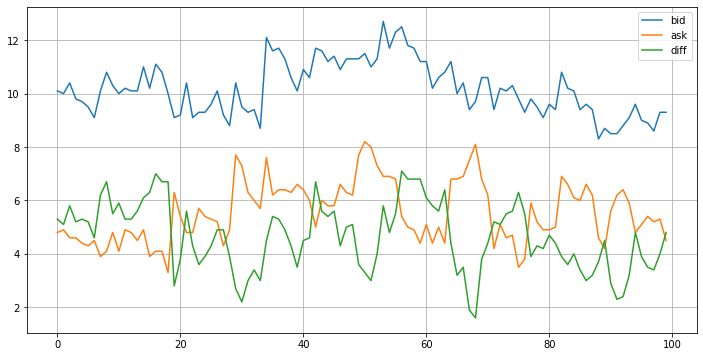

In [13]:
T = T[-100:]
plt.figure(figsize=(12, 6))
plt.plot(T[:, 1])
plt.plot(T[:, 2])
plt.plot(T[:, 3])
plt.legend(['bid', "ask", "diff"])
plt.grid()

In [15]:
n = 5

In [20]:
"{:.2f}".format(n)

'5.00'